Complex Laplacian Eigenmodes
---

Find the highest spatial corelation values achieved by the best performing eigenmodes for each canonical network:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# spectrome imports
from spectrome.brain import Brain
from spectrome.utils import functions, path
from spectrome.forward import eigenmode, runforward

In [2]:
# Some house keeping:
data_dir = "../data"

# Define frequency range of interest
fmin = 2  # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 45
fvec = np.linspace(fmin, fmax, 40)

# Load Pablo's Yeo 2017 canonical network maps
fc_dk = np.load("../data/com_dk.npy", allow_pickle=True).item()
fc_dk_normalized = pd.read_csv("../data/DK_dictionary_normalized.csv").set_index(
    "Unnamed: 0"
)

# Define variables for analysis:
alpha_vec = np.linspace(
    0.5, 4.5, 17
)  # np.linspace(0.5,5,10) # coupling strength values we are going to explore

#alpha_vec = np.linspace(0.1, 1.5, 15)

k_vec = np.linspace(0, 100, 11)  # wave numbers we are going to explore
num_fc = 7  # 7 canonical networks
num_emode = 86  # number of eigenmodes, we are using 86 region DK atlas

default_k = 20  # default wave number
default_alpha = 0.1  # default alpha

# define list of canonical network names and re-order the dictionary using these names:
fc_names = [
    "Limbic",
    "Default",
    "Visual",
    "Fronto \n parietal",
    "Somato \n motor",
    "Dorsal \n Attention",
    "Ventral \n Attention",
]
fc_dk_normalized = fc_dk_normalized.reindex(
    [
        "Limbic",
        "Default",
        "Visual",
        "Frontoparietal",
        "Somatomotor",
        "Dorsal_Attention",
        "Ventral_Attention",
    ]
).fillna(0)

# turbo color map
turbo = functions.create_turbo_colormap()

Compute Spearman correlation values:

In [3]:
# pre-allocate an array for spearman R of best performing eigenmodes:
params_bestr = np.zeros((len(alpha_vec), len(k_vec), num_fc))

# Create brain object from spectrome with HCP connectome:
hcp_brain = Brain.Brain()
hcp_brain.add_connectome(data_dir)
hcp_brain.reorder_connectome(hcp_brain.connectome, hcp_brain.distance_matrix)
hcp_brain.bi_symmetric_c()
hcp_brain.reduce_extreme_dir()

# for each network, scan through alpha and k values, compute all eigenmode's spearman R
# then select the best performing eigenmode's spearman R
for i in np.arange(0, num_fc):
    print('Computing for {} network'.format(fc_dk_normalized.index[i]))
    for a_ind in np.arange(0, len(alpha_vec)):
        for k_ind in np.arange(0, len(k_vec)):
            # get eigenmodes of complex laplacian:
            hcp_brain.decompose_complex_laplacian(alpha = alpha_vec[a_ind], k = k_vec[k_ind])
            # compute spearman correlation
            spearman_eig = eigenmode.get_correlation_df(
                hcp_brain.norm_eigenmodes, fc_dk_normalized.iloc[[i]], method = 'spearman'
            )
            params_bestr[a_ind, k_ind, i] = np.max(spearman_eig.values)

Computing for Limbic network
Computing for Default network
Computing for Visual network
Computing for Frontoparietal network
Computing for Somatomotor network
Computing for Dorsal_Attention network
Computing for Ventral_Attention network


Visualize in heatmap:

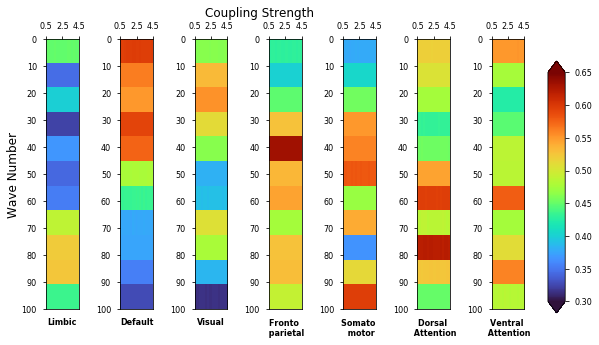

In [4]:
dynamic_range = [0.30, 0.65]
k_ticks = 11
k_labels = np.linspace(0, 100, 11).astype(int)
a_ticks = 3
a_labels = np.linspace(0.5, 4.5, 3)

with plt.style.context("seaborn-paper"):
    corr_fig, corr_ax = plt.subplots(1,7, figsize = (8,5))
    for i, ax in enumerate(corr_fig.axes):
        im = ax.imshow(np.transpose(params_bestr[:,:,i]), vmin = 0, vmax = 1, cmap = turbo, aspect = 'auto')
        ax.yaxis.set_major_locator(plt.LinearLocator(numticks = k_ticks))
        ax.xaxis.tick_top()
        ax.set_yticklabels(k_labels)
        ax.xaxis.set_major_locator(plt.LinearLocator(numticks = a_ticks))
        ax.set_xticklabels(a_labels)
        im.set_clim(dynamic_range)
        if i < 3:
            ax.set_title(fc_names[i], y=-0.08, fontsize=8, weight="bold")
        else:
            ax.set_title(fc_names[i], y=-0.12, fontsize=8, weight="bold")
            
    plt.suptitle('Coupling Strength', fontsize = 12, y = 1)
    cbar_ax = corr_fig.add_axes([1, 0.15, 0.03, 0.7])
    cb = corr_fig.colorbar(im, cax=cbar_ax, extend="both")
    corr_fig.add_subplot(1, 1, 1, frameon=False)
    plt.tick_params(labelcolor="none", top="off", bottom="off", left="off", right="off")
    plt.grid(False)
    plt.ylabel('Wave Number', fontsize = 12)
    
    plt.tight_layout()
    plt.savefig('../figures/fig5/param_bestr.png', dpi = 300, bbox_inches = 'tight')

Note - global coupling doesn't affect the best performing eigenmode but may change which eigenmode is the best performing eigenmode as well as the other eigenmodes.

Split the wave number parameter into oscillatory frequency and signal transmission velocity since wave number $k$ is defined as $k = \frac{2 \pi f}{\nu}$. Then perform the same exploratory exercise as above:

Computing for Limbic network
Computing for Default network
Computing for Visual network
Computing for Frontoparietal network
Computing for Somatomotor network
Computing for Dorsal_Attention network
Computing for Ventral_Attention network


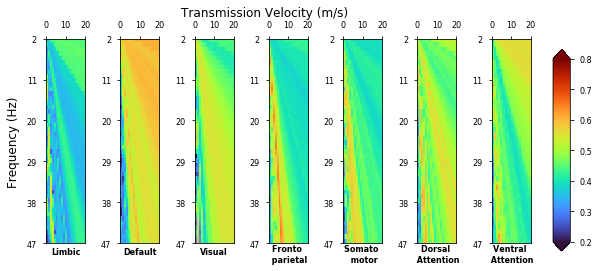

In [7]:
# define parameter ranges:
freq_vec = np.linspace(2, 47, 46)
nu_vec = np.linspace(1, 20, 21)

# define plotting visuals
dynamic_range = [0.3, 0.7]
f_ticks = 6
f_labels = np.linspace(2, 47, 6).astype(int)
nu_ticks = 3
nu_labels = np.linspace(0.5, 20, 3).astype(int)

#pre-allocate array for results
k_bestr = np.zeros((len(freq_vec), len(nu_vec), num_fc))

# compute spearman Rs:
for i in np.arange(0, num_fc):
    print('Computing for {} network'.format(fc_dk_normalized.index[i]))
    for f_ind in np.arange(0, len(freq_vec)):
        for v_ind in np.arange(0, len(nu_vec)):
            # get eigenmodes of complex laplacian:
            hcp_brain.decompose_complex_laplacian(alpha = 1, k = None, f = freq_vec[f_ind], speed = nu_vec[v_ind])
            # compute spearman correlation
            spearman_eig = eigenmode.get_correlation_df(
                hcp_brain.norm_eigenmodes, fc_dk_normalized.iloc[[i]], method = 'spearman'
            )
            k_bestr[f_ind, v_ind, i] = np.max(spearman_eig.values)
            
# Plot as above:
with plt.style.context("seaborn-paper"):
    k_fig, k_ax = plt.subplots(1,7, figsize = (8,4))
    for i, ax in enumerate(k_fig.axes):
        im = ax.imshow(k_bestr[:,:,i], vmin = 0, vmax = 1, cmap = turbo, aspect = 'auto')
        ax.yaxis.set_major_locator(plt.LinearLocator(numticks = f_ticks))
        ax.xaxis.tick_top()
        ax.set_yticklabels(f_labels)
        ax.xaxis.set_major_locator(plt.LinearLocator(numticks = nu_ticks))
        ax.set_xticklabels(nu_labels)
        im.set_clim(dynamic_range)
        if i < 3:
            ax.set_title(fc_names[i], y=-0.08, fontsize=8, weight="bold")
        else:
            ax.set_title(fc_names[i], y=-0.12, fontsize=8, weight="bold")
            
    plt.suptitle('Transmission Velocity (m/s)', fontsize = 12, y = 1)
    cbar_ax = k_fig.add_axes([1, 0.15, 0.03, 0.7])
    cb = k_fig.colorbar(im, cax=cbar_ax, extend="both")
    k_fig.add_subplot(1, 1, 1, frameon=False)
    plt.tick_params(labelcolor="none", top="off", bottom="off", left="off", right="off")
    plt.grid(False)
    plt.ylabel('Frequency (Hz)', fontsize = 12)
    
    plt.tight_layout()
    plt.savefig('../figures/fig5/k_bestr.png', dpi = 300, bbox_inches = 'tight')

Entropy
---

We want to see the entropy for all the Spearman correlation values computed with each parameter combination. The information entropy metric is defined as:

\begin{equation}
    S = - \sum_{i} \pmb{P}_i log \pmb{P}_i
\end{equation}

Entropy is generally viewed as the uncertainty when making a prediction based on available information. In the case of high entropy, we know the information we have is highly diverse and it is difficult to make any predictions. So we want to look for parameter values providing low entropy, or high fidelity.

In [8]:
from scipy.stats import entropy

params_entropy = np.zeros((len(alpha_vec), len(k_vec), num_fc))

# using the same parameter values as above
for i in np.arange(0, num_fc):
    print('Computing for {} network'.format(fc_dk_normalized.index[i]))
    for a_ind in np.arange(0, len(alpha_vec)):
        for k_ind in np.arange(0, len(k_vec)):
            # get eigenmodes of complex laplacian:
            hcp_brain.decompose_complex_laplacian(alpha = alpha_vec[a_ind], k = k_vec[k_ind])
            # compute spearman correlation
            spearman_eig = eigenmode.get_correlation_df(
                hcp_brain.norm_eigenmodes, fc_dk_normalized.iloc[[i]], method = 'spearman'
            )
            # replace negative values with 0, negative spearmanRs means no useful information
            spearman_eig[spearman_eig < 0] = 0
            #print(np.squeeze(np.asarray(spearman_eig.values)))
            params_entropy[a_ind, k_ind, i] = entropy(np.squeeze(spearman_eig.values).astype(np.float64))
        

Computing for Limbic network
Computing for Default network
Computing for Visual network
Computing for Frontoparietal network
Computing for Somatomotor network
Computing for Dorsal_Attention network
Computing for Ventral_Attention network


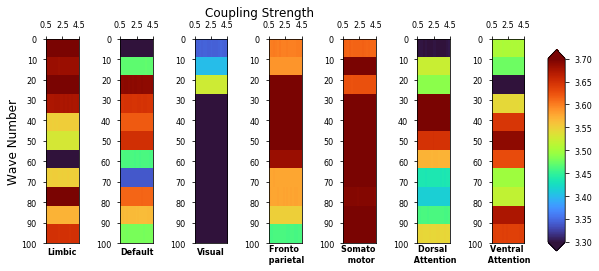

In [12]:
entropy_range = [3.3, 3.7]

# plot like before:
with plt.style.context("seaborn-paper"):
    corr_fig, corr_ax = plt.subplots(1,7, figsize = (8,4))
    for i, ax in enumerate(corr_fig.axes):
        im = ax.imshow(np.transpose(params_entropy[:,:,i]), cmap = turbo, aspect = 'auto')
        ax.yaxis.set_major_locator(plt.LinearLocator(numticks = k_ticks))
        ax.xaxis.tick_top()
        ax.set_yticklabels(k_labels)
        ax.xaxis.set_major_locator(plt.LinearLocator(numticks = a_ticks))
        ax.set_xticklabels(a_labels)
        im.set_clim(entropy_range)
        if i < 3:
            ax.set_title(fc_names[i], y=-0.08, fontsize=8, weight="bold")
        else:
            ax.set_title(fc_names[i], y=-0.12, fontsize=8, weight="bold")
            
    plt.suptitle('Coupling Strength', fontsize = 12, y = 1)
    cbar_ax = corr_fig.add_axes([1, 0.15, 0.03, 0.7])
    cb = corr_fig.colorbar(im, cax=cbar_ax, extend="both")
    corr_fig.add_subplot(1, 1, 1, frameon=False)
    plt.tick_params(labelcolor="none", top="off", bottom="off", left="off", right="off")
    plt.grid(False)
    plt.ylabel('Wave Number', fontsize = 12)
    
    plt.tight_layout()